[INFO] Loading price series for SPY from 2015-01-01 ...
[INFO] Got 2739 daily observations after cleaning.
[INFO] Running walk-forward backtest ...
[INFO] Computing metrics ...

[SUMMARY] Metrics:
  auc: 0.4908561928512053
  accuracy: 0.5520110957004161
  hit_ratio_long: 0.5556612749762131
  terminal_equity_strategy: 2.8933752986299863
  terminal_equity_buyhold: 2.8895260315621183
  excess_equity: 0.003849267067868034
  strategy_ann_return: 0.14143517627169222
  strategy_ann_vol: 0.18731266814097378
  strategy_sharpe: 0.7550753383388165


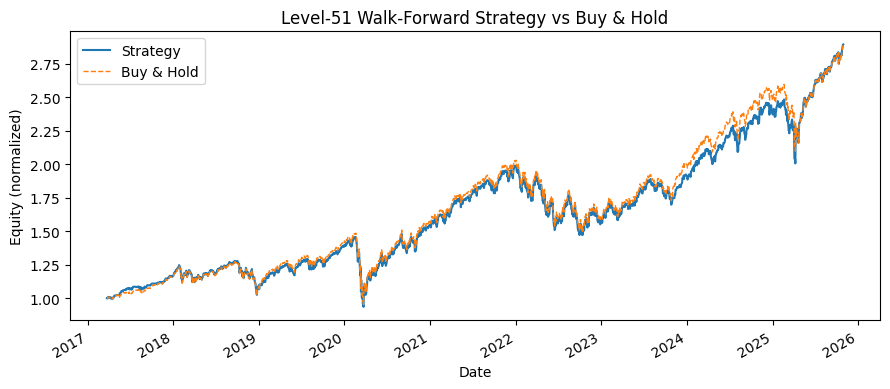

In [1]:
"""
Level-51 — Walk-Forward Expanding-Window Trend Classifier (Logistic Regression)

Description:
    We build a walk-forward expanding-window backtest for a simple binary
    classifier that predicts whether tomorrow's return will be positive.
    The model is a logistic regression trained on rolling, growing prefixes
    of the time series, and evaluated on forward chunks of data. For each
    step we:
        1) Train on all data up to a certain date.
        2) Predict up/down for the next 'step' days.
        3) Aggregate all out-of-sample predictions into a single evaluation.

    We then convert prediction probabilities into a simple long/flat strategy:
        - If prob(up) >= 0.5 → take a long position for the next day.
        - Else → stay flat.
    We compare this strategy to a naive buy-and-hold on the same asset.

DSA Concept (detailed):
    1) Expanding Window Prefix Slices:
       We treat the time index as an ordered array of length N. At each
       walk-forward iteration, we pick a "train_end" index and define:
           train_indices = idx[:train_end]
           test_indices  = idx[train_end : train_end + step]
       This is classic prefix/suffix slicing on 1-D arrays. The training
       window grows over time (expanding window), which is a simple DSA
       pattern on indices.

    2) Sequential Backtest Loop:
       Using a for-loop over integer split points, we repeatedly fit and test:
           for train_end in range(train_min, n - step, step):
               # slice train, slice test, fit model, predict
       This is a controlled traversal over a 1-D index. The complexity is
       O(K * cost_fit) where K is the number of walk-forward steps.

    3) Efficient Accumulation:
       Each iteration produces a small DataFrame of predictions over that
       test window. Instead of concatenating directly in the loop, we append
       to a list and concatenate once at the end:
           chunks = []
           chunks.append(chunk)
           ...
           preds = pd.concat(chunks).sort_index()
       This is a standard DSA technique to avoid repeated O(n^2)-ish merges.

    4) Temporal Alignment via Shifts:
       We ensure no look-ahead by using today's predicted probability for
       tomorrow's trade. In Series terms:
           strategy_ret[t] = signal[t-1] * ret[t]
       We implement this with a shift:
           signal_shifted = signal.shift(1).fillna(0)
       This is a simple index transform on a 1-D array but is critical for
       correct temporal logic.

    5) Rolling and EWM Features:
       Features such as rolling volatility and exponential moving averages
       are built with sliding windows and recursive updates. Conceptually:
           - Rolling windows behave like fixed-size queues traversing the array.
           - EWMA is a one-pass recursive filter (DP-like recurrence).

Real-Time / Practical Relevance:
    - This is exactly how many production quant systems validate strategies:
      they simulate "train on the past, predict the unknown future" instead
      of random shuffling.
    - You can plug in any model in place of logistic regression as long as it
      supports fit(X_train, y_train) and predict_proba(X_test).

Outputs:
    - level51_walkforward_predictions.csv
        index: date
        columns: ['proba_up', 'pred_label', 'true_label', 'ret',
                  'signal', 'strategy_ret', 'equity_strategy', 'equity_buyhold']
    - level51_walkforward_metrics.json
        aggregate metrics: AUC, accuracy, hit ratio, terminal equity, etc.

Free Data:
    - Uses yfinance for daily prices with a synthetic fallback if download
      fails or there is no internet.

Difficulty: Intermediate.
"""

from __future__ import annotations

import json
from dataclasses import dataclass, asdict
from typing import List, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


# --------------------------- Config --------------------------- #

@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2015-01-01"

    # Label horizon: 1 = predict next-day direction
    label_horizon: int = 1

    # Walk-forward parameters (in number of daily bars)
    train_min_bars: int = 500        # minimum bars in first training window
    step_bars: int = 21              # re-train roughly every month

    # Output files
    out_preds_csv: str = "level51_walkforward_predictions.csv"
    out_metrics_json: str = "level51_walkforward_metrics.json"


# --------------------------- Data Utilities --------------------------- #

def generate_synthetic(cfg: Config, n: int = 1500) -> pd.DataFrame:
    """
    Synthetic fallback: random-walk price with mild drift and noise.
    """
    idx = pd.date_range(cfg.start, periods=n, freq="B")
    rng = np.random.default_rng(42)
    steps = rng.normal(loc=0.0003, scale=0.01, size=n)
    price = 100 + np.cumsum(steps)
    price = np.maximum(price, 1.0)

    df = pd.DataFrame({"close": price}, index=idx)
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna()
    return df


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Download daily adjusted close prices from yfinance and compute log returns.
    Fallback to synthetic data if download fails or returns empty.

    Defensive handling for:
        - DataFrame with 'Close'
        - MultiIndex columns (e.g., ('Close', 'SPY'))
        - 2D shapes (n, 1)
    """
    try:
        px = yf.download(
            cfg.symbol,
            start=cfg.start,
            auto_adjust=True,
            progress=False
        )
    except Exception:
        px = pd.DataFrame()

    if px is None or px.empty:
        print("[WARN] yfinance download failed or empty; using synthetic series.")
        return generate_synthetic(cfg)

    # Handle Series directly
    if isinstance(px, pd.Series):
        close = px.astype(float).rename("close")

    else:
        close_obj = None

        # Simple columns
        if "Close" in px.columns:
            close_obj = px["Close"]

        # MultiIndex columns
        elif isinstance(px.columns, pd.MultiIndex):
            if ("Close", cfg.symbol) in px.columns:
                close_obj = px[("Close", cfg.symbol)]
            else:
                try:
                    sub = px.xs("Close", axis=1, level=0)
                    close_obj = sub.iloc[:, 0]
                except Exception:
                    close_obj = px.iloc[:, 0]

        # Fallback: first column
        if close_obj is None:
            close_obj = px.iloc[:, 0]

        if isinstance(close_obj, pd.DataFrame):
            close_obj = close_obj.iloc[:, 0]

        arr = np.asarray(close_obj).reshape(-1)
        close = pd.Series(arr, index=px.index, name="close").astype(float)

    df = pd.DataFrame({"close": close})
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna()
    return df


# --------------------------- Feature Engineering --------------------------- #

def compute_rsi(close: pd.Series, window: int = 14) -> pd.Series:
    """
    Compute RSI (Relative Strength Index) using an EMA-style formulation.

    RSI is a classic technical indicator:
        RSI = 100 - 100 / (1 + RS)
        RS = avg_gain / avg_loss

    Here we use exponential moving averages of gains and losses.
    """
    delta = close.diff()
    up = delta.clip(lower=0.0)
    down = -delta.clip(upper=0.0)

    roll_up = up.ewm(alpha=1.0 / window, adjust=False).mean()
    roll_down = down.ewm(alpha=1.0 / window, adjust=False).mean()

    rs = roll_up / roll_down.replace(0.0, np.nan)
    rsi = 100.0 - 100.0 / (1.0 + rs)
    return rsi


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a small set of price-based features:
        - ret: daily log return
        - vol_20, vol_60: rolling volatility
        - ema_fast (10), ema_slow (50)
        - ema_ratio: ema_fast / ema_slow - 1
        - rsi_14: RSI(14)
    """
    close = df["close"]
    ret = df["ret"]

    feat = pd.DataFrame(index=df.index)
    feat["ret"] = ret

    feat["vol_20"] = ret.rolling(20).std()
    feat["vol_60"] = ret.rolling(60).std()

    ema_fast = close.ewm(span=10, adjust=False).mean()
    ema_slow = close.ewm(span=50, adjust=False).mean()
    feat["ema_fast"] = ema_fast
    feat["ema_slow"] = ema_slow
    feat["ema_ratio"] = ema_fast / ema_slow - 1.0

    feat["rsi_14"] = compute_rsi(close, window=14)

    feat = feat.dropna()
    return feat


def build_labels(df: pd.DataFrame, horizon: int) -> pd.Series:
    """
    Binary label: 1 if close_{t+horizon} > close_t else 0.
    For horizon=1, it's "tomorrow up vs not".
    """
    close = df["close"]
    future_close = close.shift(-horizon)
    label = (future_close > close).astype(int)
    label = label.dropna()
    return label


# --------------------------- Walk-Forward Backtest --------------------------- #

def walk_forward_backtest(
    feat: pd.DataFrame,
    labels: pd.Series,
    df_prices: pd.DataFrame,
    cfg: Config
) -> pd.DataFrame:
    """
    Perform an expanding-window walk-forward backtest:

        - Align features, labels, and returns on a common index.
        - Starting from 'train_min_bars', step forward in chunks of 'step_bars'.
        - For each step:
            * Train logistic regression on all data up to train_end.
            * Predict probabilities on [train_end : train_end + step_bars).
        - Aggregate all out-of-sample predictions and build a long/flat strategy.

    Returns:
        preds: DataFrame indexed by date with columns:
            ['proba_up', 'pred_label', 'true_label',
             'ret', 'signal', 'strategy_ret',
             'equity_strategy', 'equity_buyhold']
    """
    # Align everything
    idx_common = feat.index.intersection(labels.index).intersection(df_prices.index)
    feat = feat.loc[idx_common]
    labels = labels.loc[idx_common]
    rets = df_prices.loc[idx_common, "ret"]

    n = len(idx_common)
    if n < cfg.train_min_bars + cfg.step_bars + 10:
        raise RuntimeError("Not enough data for walk-forward; try smaller train_min_bars or step_bars.")

    chunks: List[pd.DataFrame] = []

    for train_end in range(cfg.train_min_bars, n - cfg.step_bars, cfg.step_bars):
        test_end = train_end + cfg.step_bars

        idx_train = idx_common[:train_end]
        idx_test = idx_common[train_end:test_end]

        X_train = feat.loc[idx_train]
        y_train = labels.loc[idx_train]
        X_test = feat.loc[idx_test]
        y_test = labels.loc[idx_test]

        # If class is degenerate, skip this window
        if y_train.nunique() < 2:
            continue

        model = LogisticRegression(
            solver="lbfgs",
            max_iter=1000
        )
        model.fit(X_train, y_train)

        proba = model.predict_proba(X_test)[:, 1]
        pred_label = (proba >= 0.5).astype(int)

        chunk = pd.DataFrame(
            {
                "proba_up": proba,
                "pred_label": pred_label,
                "true_label": y_test.values,
                "ret": rets.loc[idx_test].values,
            },
            index=idx_test,
        )
        chunks.append(chunk)

    if not chunks:
        raise RuntimeError("No valid walk-forward windows produced predictions.")

    preds = pd.concat(chunks).sort_index()

    # Build trading signal: use today's probability to trade tomorrow's return
    preds["signal"] = (preds["proba_up"] >= 0.5).astype(int)

    # Align with returns and compute strategy P&L
    # We already stored 'ret' as daily log returns at the same index.
    # Use lagged signal to avoid look-ahead.
    preds["signal_lag"] = preds["signal"].shift(1).fillna(0)
    preds["strategy_ret"] = preds["signal_lag"] * preds["ret"]

    preds["equity_strategy"] = (1.0 + preds["strategy_ret"]).cumprod()
    preds["equity_buyhold"] = (1.0 + preds["ret"]).cumprod()

    return preds


# --------------------------- Metrics & I/O --------------------------- #

def compute_metrics(preds: pd.DataFrame) -> Dict[str, float]:
    """
    Compute summary metrics from the walk-forward predictions.
    """
    true = preds["true_label"].values
    proba = preds["proba_up"].values
    pred = preds["pred_label"].values

    metrics: Dict[str, float] = {}

    # AUC
    try:
        metrics["auc"] = float(roc_auc_score(true, proba))
    except Exception:
        metrics["auc"] = float("nan")

    # Accuracy
    metrics["accuracy"] = float(accuracy_score(true, pred))

    # Hit ratio when model predicts up (precision on class "1")
    mask_up = pred == 1
    if mask_up.sum() > 0:
        metrics["hit_ratio_long"] = float((true[mask_up] == 1).mean())
    else:
        metrics["hit_ratio_long"] = float("nan")

    # Strategy / buy-and-hold stats
    eq_strat = preds["equity_strategy"].iloc[-1]
    eq_bh = preds["equity_buyhold"].iloc[-1]

    metrics["terminal_equity_strategy"] = float(eq_strat)
    metrics["terminal_equity_buyhold"] = float(eq_bh)
    metrics["excess_equity"] = float(eq_strat - eq_bh)

    # Rough annualized return & vol from strategy
    n_days = len(preds)
    if n_days > 2:
        strat_ret = preds["strategy_ret"]
        mean_daily = strat_ret.mean()
        vol_daily = strat_ret.std()
        metrics["strategy_ann_return"] = float(mean_daily * 252)
        metrics["strategy_ann_vol"] = float(vol_daily * np.sqrt(252))
        metrics["strategy_sharpe"] = (
            float(mean_daily / vol_daily * np.sqrt(252)) if vol_daily > 0 else float("nan")
        )
    else:
        metrics["strategy_ann_return"] = float("nan")
        metrics["strategy_ann_vol"] = float("nan")
        metrics["strategy_sharpe"] = float("nan")

    return metrics


def save_outputs(preds: pd.DataFrame, metrics: Dict[str, float], cfg: Config) -> None:
    """
    Save predictions to CSV and metrics to JSON.
    """
    # Drop signal_lag from final CSV for compactness (optional)
    out_preds = preds.drop(columns=["signal_lag"])
    out_preds.to_csv(cfg.out_preds_csv, index_label="date")

    with open(cfg.out_metrics_json, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)


def plot_equity_curves(preds: pd.DataFrame) -> None:
    """
    Plot equity curves of the strategy vs buy-and-hold.
    """
    plt.figure(figsize=(9, 4))
    preds["equity_strategy"].plot(label="Strategy", linewidth=1.5)
    preds["equity_buyhold"].plot(label="Buy & Hold", linewidth=1.0, linestyle="--")
    plt.title("Level-51 Walk-Forward Strategy vs Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Equity (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------------------------- Main Orchestration --------------------------- #

def run_level51(cfg: Config) -> None:
    """
    Orchestrates:
        1) Load price series.
        2) Build features & labels.
        3) Run walk-forward backtest.
        4) Compute metrics, save outputs, and plot equity curves.
    """
    print(f"[INFO] Loading price series for {cfg.symbol} from {cfg.start} ...")
    df = load_price_series(cfg)
    print(f"[INFO] Got {len(df)} daily observations after cleaning.")

    feat = build_features(df)
    labels = build_labels(df, cfg.label_horizon)

    # The walk-forward function realigns indices internally
    print("[INFO] Running walk-forward backtest ...")
    preds = walk_forward_backtest(feat, labels, df, cfg)

    print("[INFO] Computing metrics ...")
    metrics = compute_metrics(preds)

    save_outputs(preds, metrics, cfg)

    print("\n[SUMMARY] Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")

    try:
        plot_equity_curves(preds)
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")


# --------------------------- Script Entrypoint --------------------------- #

if __name__ == "__main__":
    # Jupyter-safe: strip out '-f <kernel>.json' if present
    import sys
    if len(sys.argv) > 1:
        sys.argv = [sys.argv[0]]

    cfg = Config()
    run_level51(cfg)
